In [10]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras import Sequential
from keras.layers import Dense,Dropout, BatchNormalization,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
data_dir = 'D:\Courses\DataScienceTMS\HW37\VincentVanGogh\Saint Remy'

In [3]:
def load_images_from_folder(folder, img_height, img_width):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith('.png') or img_path.endswith('.jpg') or img_path.endswith('.jpeg'):
            img = Image.open(img_path).convert('L')
            img = img.resize((img_width, img_height))
            img_array = img_to_array(img)
            images.append(img_array)
    return np.array(images)

x_train = load_images_from_folder(data_dir, 28, 28)

x_train = x_train.astype('float32') / 255.0
print(x_train.shape)

(143, 28, 28, 1)


In [4]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(decoder_inputs, decoder_outputs, name="decoder")

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling((z_mean, z_log_var))
        return self.decoder(z)

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

vae = VAE(encoder, decoder)
vae.compile(optimizer='adam', loss='mse')

# 3. Обучение VAE
vae.fit(x_train, x_train, epochs=10, batch_size=32)

Epoch 1/10
5/5 [==============================] - 1s 17ms/step - loss: 0.0379
Epoch 2/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0370
Epoch 3/10
5/5 [==============================] - 0s 17ms/step - loss: 0.0358
Epoch 4/10
5/5 [==============================] - 0s 14ms/step - loss: 0.0348
Epoch 5/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0342
Epoch 6/10
5/5 [==============================] - 0s 17ms/step - loss: 0.0340
Epoch 7/10
5/5 [==============================] - 0s 17ms/step - loss: 0.0338
Epoch 8/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0335
Epoch 9/10
5/5 [==============================] - 0s 15ms/step - loss: 0.0333
Epoch 10/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0328


In [5]:
def transfer_style(content_image_path, style_image_path):
    content_image = image.load_img(content_image_path, target_size=(28, 28))
    content_image = image.img_to_array(content_image)
    content_image = cv2.cvtColor(content_image, cv2.COLOR_BGR2GRAY)
    content_image = content_image.astype('float32') / 255.
    content_image = np.expand_dims(content_image, axis=0)

    style_image = image.load_img(style_image_path, target_size=(28, 28))
    style_image = image.img_to_array(style_image)
    style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2GRAY)
    style_image = style_image.astype('float32') / 255.
    style_image = np.expand_dims(style_image, axis=0)

    content_encoded = encoder.predict(content_image)[0]
    style_encoded = encoder.predict(style_image)[0]
    combined_encoded = (content_encoded + style_encoded) / 2.0

    transferred_image = decoder.predict(combined_encoded)

    return transferred_image

In [6]:
result_image = transfer_style('Babrujskaja,_Minsk.jpg', 'VincentVanGogh\Saint Remy\Starry Night.jpg')

1/1 [==============================] - 0s 81ms/step


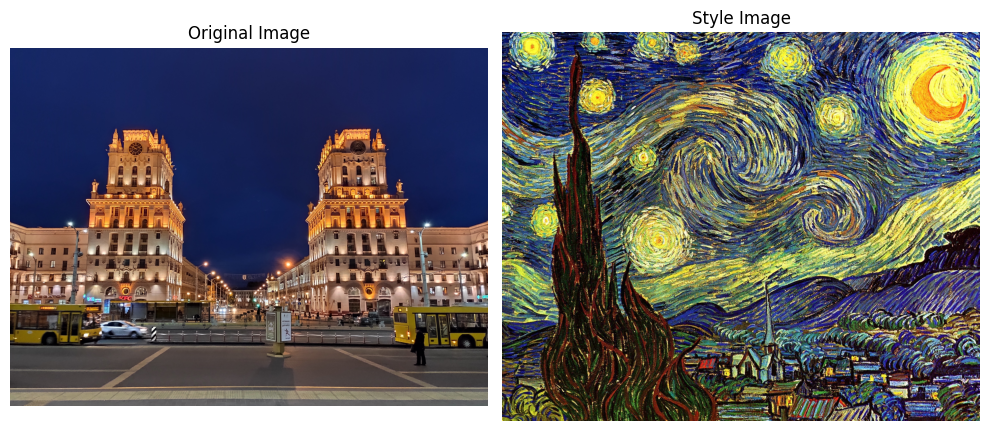

In [7]:
import matplotlib.pyplot as plt

def display_images(original, stylized):
    plt.figure(figsize=(10, 5))

    # Отображение исходного изображения
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')

    # Отображение стилизованного изображения
    plt.subplot(1, 2, 2)
    plt.imshow(stylized)
    plt.title("Style Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

original_image = plt.imread('Babrujskaja,_Minsk.jpg')
stylized_image = plt.imread('VincentVanGogh\Saint Remy\Starry Night.jpg')
display_images(original_image, stylized_image)

## Style Transfer using VGG19

In [29]:
import tensorflow as tf
import tensorflow.keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [22]:
content_path = 'img_0.jpg'
style_path = 'frame5027.jpg'

In [30]:
def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)))
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array, axis=0) 
    return im_array

def show_im(img,title=None):
    img = np.squeeze(img, axis=0)
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))

In [31]:
content = load_file(content_path)
style = load_file(style_path)

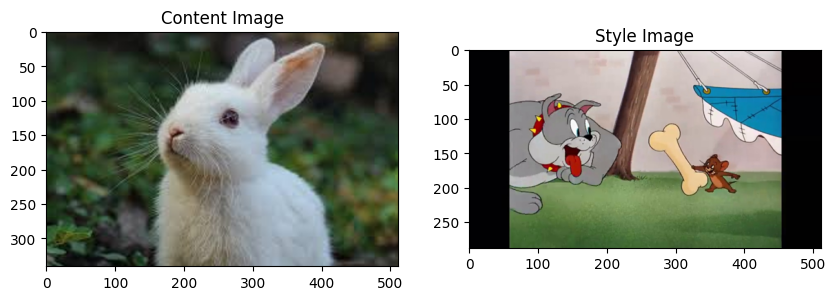

In [32]:
plt.figure(figsize=(10,10))
content = load_file(content_path)
style = load_file(style_path)
plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

In [33]:
def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

In [34]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [35]:
im=img_preprocess(content_path)

In [36]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

In [37]:
def get_model():
    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers]
    style_output=[vgg.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

In [38]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
model.summary()

80134624/80134624 [==============================] - 12s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                             

In [39]:
model=get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 15,304,768
Trainable params: 0
Non-trainable params: 15,304,768
_________________________________________________________________


In [40]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss

def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    
    content_output=model(content_img)
    style_output=model(style_image)
    
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature

In [41]:
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights
    
    output=model(image)
    content_loss=0
    style_loss=0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    
    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)
        
    
    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)
        
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    return total_loss,style_loss,content_loss

In [42]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [43]:
def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e-2):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

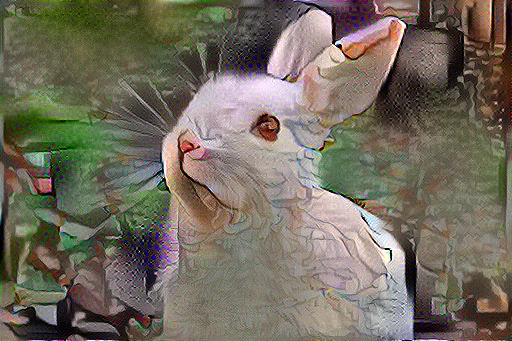

Epoch: 495
Total loss: 2.3865e+06, style loss: 1.6053e+06, content loss: 7.8127e+05, 


In [44]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=500)

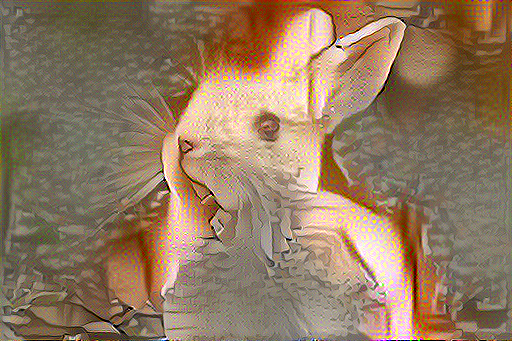

Epoch: 495
Total loss: 2.7083e+06, style loss: 1.7877e+06, content loss: 9.2066e+05, 


In [47]:
style_path = '1.jpg'

best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=500)